In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from qick import *

In [ ]:
### IF YOU NEED TO REPROGRAM THE CLOCKS ###
#import xrfclk 
#xrfclk.set_ref_clks(lmk_freq=245.76, lmx_freq=491.52)

### IF YOU NEED TO CLEAR CACHE ###
#from pynq.pl_server.global_state import clear_global_state
#clear_global_state()

In [3]:
soc = QickSoc(bitfile='/home/xilinx/jupyter_notebooks/TII_QICK/qick/qick_demos/custom/drivers/base_MTS_15.bit')
soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.267
	Firmware timestamp: Tue Nov 19 17:20:20 2024

	Global clocks (MHz): tProcessor 350.000, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=3

In [4]:
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/qick/qick_demos/custom/drivers')

from TIDAC80508 import TIDAC80508
tidac = TIDAC80508()

In [5]:
### SET POWER FOR DACs ###
dac_2280 = soccfg.usp_rf_data_converter_0.dac_tiles[0].blocks[0]
dac_2280.SetDACVOP(40000)
dac_2281 = soccfg.usp_rf_data_converter_0.dac_tiles[0].blocks[1]
dac_2281.SetDACVOP(40000)
dac_2282 = soccfg.usp_rf_data_converter_0.dac_tiles[0].blocks[2]
dac_2282.SetDACVOP(40000)
dac_2283 = soccfg.usp_rf_data_converter_0.dac_tiles[0].blocks[3]
dac_2283.SetDACVOP(40000)

dac_2292 = soccfg.usp_rf_data_converter_0.dac_tiles[1].blocks[2]
dac_2292.SetDACVOP(40000)

dac_2230 = soccfg.usp_rf_data_converter_0.dac_tiles[2].blocks[0]
dac_2230.SetDACVOP(40000)
dac_2232 = soccfg.usp_rf_data_converter_0.dac_tiles[2].blocks[2]
dac_2232.SetDACVOP(40000)

In [6]:
### ENABLE MULTI TILE SYNCHRONIZATION ###
soccfg.usp_rf_data_converter_0.mts_dac_config.RefTile = 2
soccfg.usp_rf_data_converter_0.mts_dac_config.Tiles = 0b0001
soccfg.usp_rf_data_converter_0.mts_dac_config.SysRef_Enable = 1
soccfg.usp_rf_data_converter_0.mts_dac_config.Target_Latency = -1
soccfg.usp_rf_data_converter_0.mts_dac()

In [7]:
FLUX         = [0,1]
DRIVE        = [2,3,4,5]
PROBE_CH     = 6
FEEDBACK_PFB = [0,1,2,3] #ADC
MAX_GAIN     = 32766  

In [8]:
class MuxProgram(AveragerProgram):    
    def initialize(self):
        cfg=self.cfg
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        flux_1  = cfg['flux'][0]   
        drive_1 = cfg['drive'][0]
        drive_2 = cfg['drive'][1]

        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mux_freqs = cfg['pulse_freqs'], mux_gains = cfg['pulse_gains'], mux_phases = cfg['pulse_phases'])
        for iCh, ch in enumerate(ro_chs):
            self.declare_readout(ch = ch, freq = cfg['pulse_freqs'][iCh], length = self.us2cycles(self.cfg['ro_len'], ro_ch=ch), gen_ch = gen_ch)        
        self.set_pulse_registers(ch = gen_ch, style = 'const', length=self.us2cycles(cfg["pulse_len_ro"], gen_ch=gen_ch), mask=[0,1,2,3])
        
        self.declare_gen(ch=drive_1, nqz=2)
        self.add_gauss(ch=drive_1, name="gauss1", sigma=self.us2cycles(cfg['pulse_len_gauss'], gen_ch=drive_1)/5, length=self.us2cycles(cfg['pulse_len_gauss'], gen_ch=drive_1), even_length=True)
        self.set_pulse_registers(ch=drive_1, gain=MAX_GAIN, freq=self.freq2reg(cfg["freq2"], gen_ch=drive_1), phase=self.deg2reg(0, gen_ch=drive_1), style="arb", waveform="gauss1")

        self.declare_gen(ch=drive_2, nqz=2)
        self.add_gauss(ch=drive_2, name="gauss2", sigma=self.us2cycles(cfg['pulse_len_gauss'], gen_ch=drive_2)/5, length=self.us2cycles(cfg['pulse_len_gauss'], gen_ch=drive_2), even_length=True)
        self.set_pulse_registers(ch=drive_2, gain=MAX_GAIN, freq=self.freq2reg(cfg["freq2"], gen_ch=drive_2), phase=self.deg2reg(0, gen_ch=drive_2), style="arb", waveform="gauss2")
        
        flux_pulse_length = 16 * int(self.cfg["pulse_len_flux"] * 384)
        time  = np.arange(0, flux_pulse_length) * self.cfg["pulse_len_flux"] / flux_pulse_length
        flux_i = 0.5 * (1 + np.exp(0.1 * time))      
        self.declare_gen(ch=flux_1, nqz=1)
        self.add_envelope(ch=flux_1, name="rfpulse", idata=0.95*MAX_GAIN*flux_i, qdata=None)
        self.set_pulse_registers(ch=flux_1, style="arb", waveform="rfpulse", freq=cfg['freq1'], phase=0, gain=MAX_GAIN, outsel="input")         
        
        self.synci(500)
    
    def body(self):
        cfg = self.cfg
        self.pulse(ch=cfg['drive'][0], t=0)
        #self.pulse(ch=cfg['drive'][1], t=0)       
        #self.pulse(ch=cfg['flux'][0],  t=0) 
        self.measure(pulse_ch = cfg['gen_ch'], adcs = cfg['ro_chs'], adc_trig_offset = self.us2cycles(self.cfg['trig_time']), t=self.us2cycles(0))

In [21]:
config = {'drive': DRIVE,
          'flux':  FLUX,
          'gen_ch': PROBE_CH,
          'ro_chs': FEEDBACK_PFB,
          'mixer_freq': 5000,
          'nqz': 2,
          'pulse_freqs':  5000 + np.arange(4)*50,
          'pulse_gains':  [1,1,1,1],
          'pulse_phases': [0,0,0,0],
          'ro_phases':    [0,0,0,0],
          'trig_time': 0.7,
          'freq1': 0,
          'freq2': 4500,
          'pulse_len_flux' : 70/430.08,
          'pulse_len_gauss': 70/430.08,
          'pulse_len_ro': 700/430.08,
          'ro_len': 710/430.08,
          'reps'        : 1,
         }

  0%|          | 0/1 [00:00<?, ?it/s]

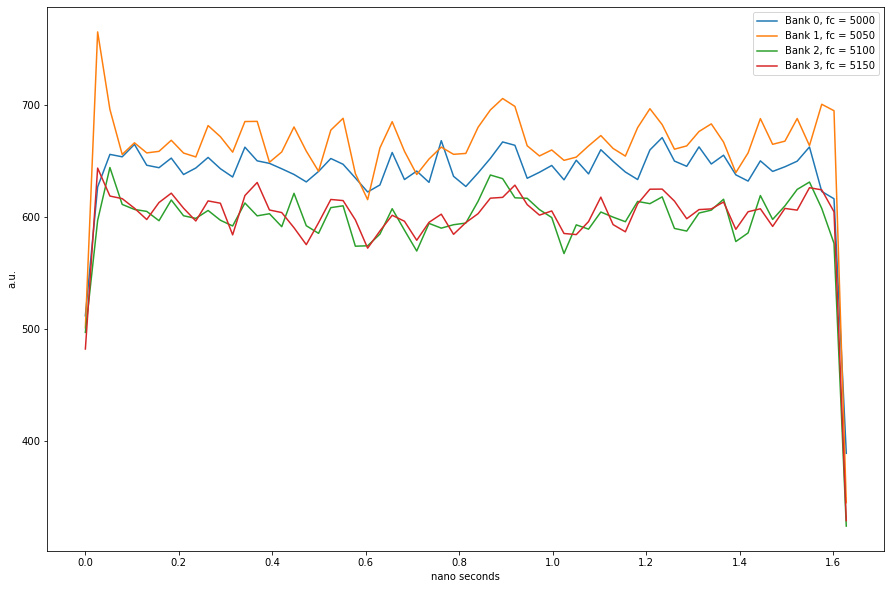

In [22]:
#############################################
### PLOT PROGRAM OF AveragerProgram CLASS ###
#############################################

prog = MuxProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, start_src="internal", load_pulses=True)

t = np.linspace(0, config["pulse_len_ro"], len(iq_list[0][0]))
plt.figure(figsize=(15,10))
for ii, iq in enumerate(iq_list):
    plt.plot(t, np.abs(iq[0]+1j*iq[1]), label="Bank {}, fc = {}".format(ii, config["pulse_freqs"][ii]))
plt.ylabel("a.u.")
plt.xlabel("nano seconds")
plt.legend()
plt.show()